In [2]:
library(tidyverse)
library(tidymodels)
library(readxl)

raisin_data <- read_csv("https://github.com/dylankim990/DSCI100_Group_1/raw/main/data/Raisin_Dataset.csv") %>% mutate(Class = as_factor(Class))

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

In [3]:
#1. choose columns; forward selection 
#2. choose K; cross-validation
#3. predict and find accuracy on testing set; train and predict 
#4. compare the model prediction with other research model predictions

#### 1. choose columns; forward selection 

Before finding K through cross-validation, we will be using forward selection to find the best combination of predictors that shows highest accuracy rates. For efficiency, we eliminated the combinations with too many predictors. Since selecting predictors is a part of tuning my classifier, we have only used training dataset for the process. Below is the codes. There are two forloops. First one increases the predictor set sizes and the second one selects which predictor to add, by checking which one gives the best accuracy rate. For each combination of predictors, the loop created a recipe, with scaling, and inserted into a workflow to tune the K-NN classifier using 5-fold cross-validation. Then, we have visualized the Number of Predictors against Estimated Accuracy. The combination of the two predictors:  Perimeter and Eccentricity was selected. Although the combination of three predictor, which also includes Area, had less than a 0.005 accuracy higher, but we found that such small increase in accuracy is not worth increasing the complexity of increasing number of predictors. 

size,model_string,accuracy
<int>,<chr>,<dbl>
1,Class ~ Perimeter,0.8562774
2,Class ~ Perimeter+Eccentricity,0.8651010
3,Class ~ Perimeter+Eccentricity+Area,0.8696444
4,Class ~ Perimeter+Eccentricity+Area+MajorAxisLength,0.8681299
5,Class ~ Perimeter+Eccentricity+Area+MajorAxisLength+ConvexArea,0.8637182
6,Class ~ Perimeter+Eccentricity+Area+MajorAxisLength+ConvexArea+Extent,0.8651229
7,Class ~ Perimeter+Eccentricity+Area+MajorAxisLength+ConvexArea+Extent+MinorAxisLength,0.8680641


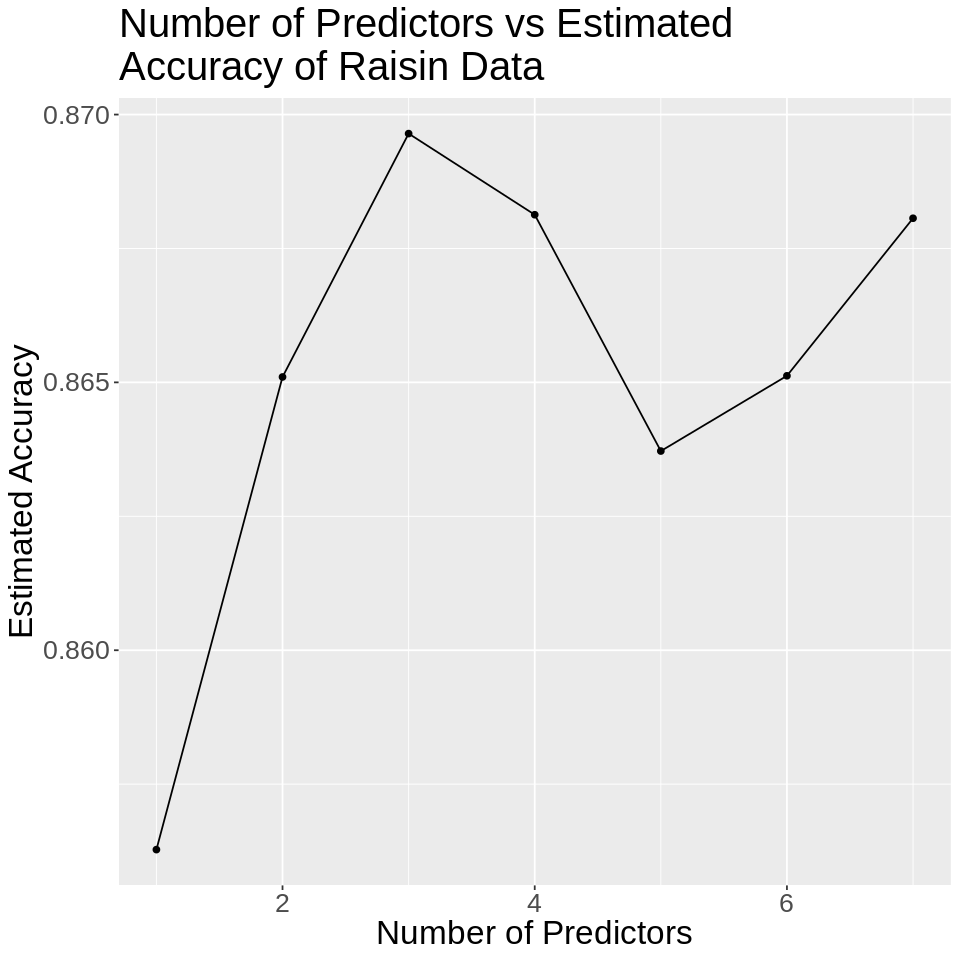

In [4]:
set.seed(5805)
raisin_split <- initial_split(raisin_data, prop = 0.75 ,strata = Class)
raisin_training <- training(raisin_split)
raisin_testing <- testing(raisin_split)

raisin_subset <- raisin_training %>%
  select(Area,
         MajorAxisLength, 
         MinorAxisLength, 
         Eccentricity, 
         ConvexArea, 
         Extent, 
         Perimeter, 
         Class)

names <- colnames(select(raisin_subset, -Class))
# creating an empty tibble which will store the accuracy results
accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())
# create a model 
knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) %>%
     set_engine("kknn") %>%
     set_mode("classification")
# 5-fold cross-validation
raisin_vfold <- vfold_cv(raisin_subset, v = 5, strata = Class)

# total # of predictors
n_total <- length(names)

# creating to store selected predictors
selected <- c()
#loops to try all the models
# for every size from 1 to the total number of predictors
for (i in 1:n_total) {
    # for every predictor still not added yet
    accs <- list()
    models <- list()

#inner loop for model string for different combinations of predictors
    for (j in 1:length(names)) {
        # create a model string for the combinations of predictors
        preds_new <- c(selected, names[[j]])
        model_string <- paste("Class", "~", paste(preds_new, collapse="+"))
        
# created a recipe from the model string
        raisin_recipe <- recipe(as.formula(model_string), 
                                data = raisin_subset) %>%
                          step_scale(all_predictors()) %>%
                          step_center(all_predictors())
        
# tune the KNN classifier with these predictors, 
# and collect the accuracy for the best K
        acc <- workflow() %>%
          add_recipe(raisin_recipe) %>%
          add_model(knn_spec) %>%
          tune_grid(resamples = raisin_vfold, grid = 10) %>%
          collect_metrics() %>%
          filter(.metric == "accuracy") %>%
          summarize(mx = max(mean))
        acc <- acc$mx %>% unlist()

# adding the result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
        accuracies <- accuracies %>% 
          add_row(size = i, 
                  model_string = models[[jstar]], 
                  accuracy = accs[[jstar]])
        selected <- c(selected, names[[jstar]])
        names <- names[-jstar]
}
accuracies
options(repr.plot.width = 8, repr.plot.height = 8)

accuracies_plot <- ggplot(accuracies, aes(x = size, y = accuracy)) +
    geom_point() +
    geom_line() +
    labs(x = "Number of Predictors", y = "Estimated Accuracy", title = "Number of Predictors vs Estimated 
Accuracy of Raisin Data") +
    theme(text = element_text(size = 20))

accuracies_plot

#### 2. choose K; cross-validation

We found that K = 11 has the highest accuracy. And K = 11 was not extremely high number of neighbors, so we decided to pick the highest.

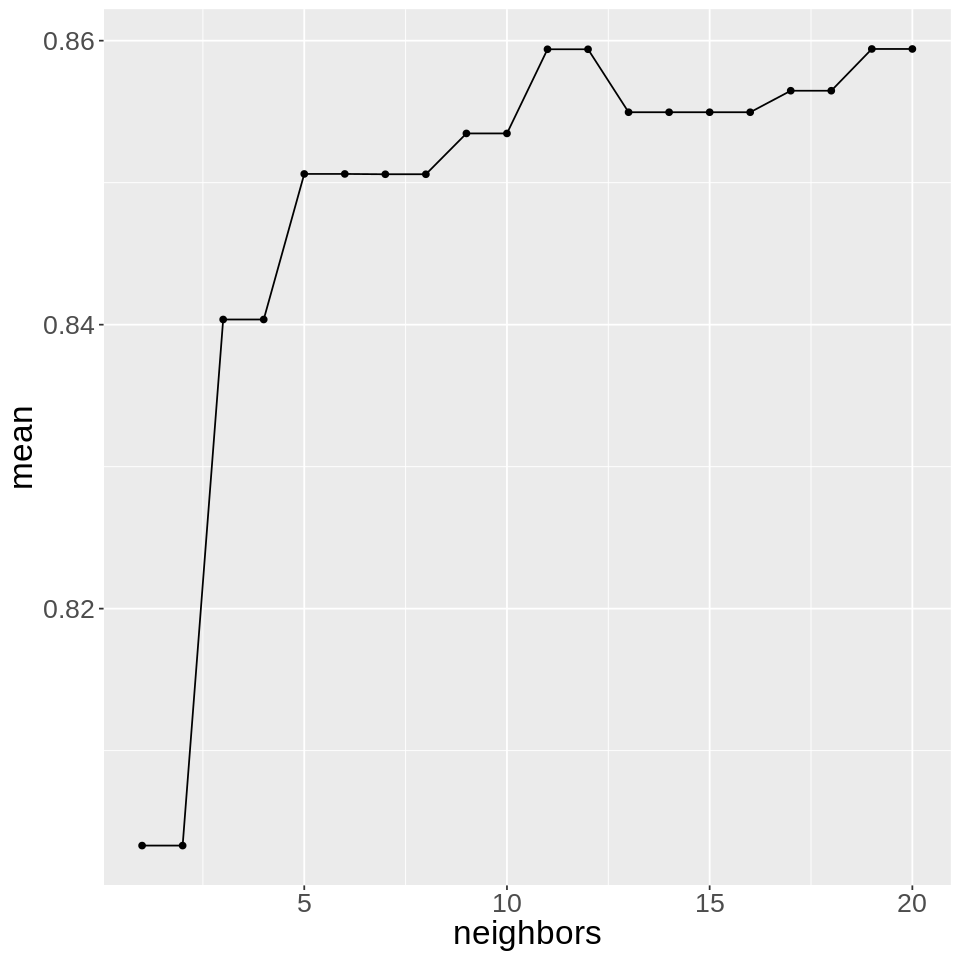

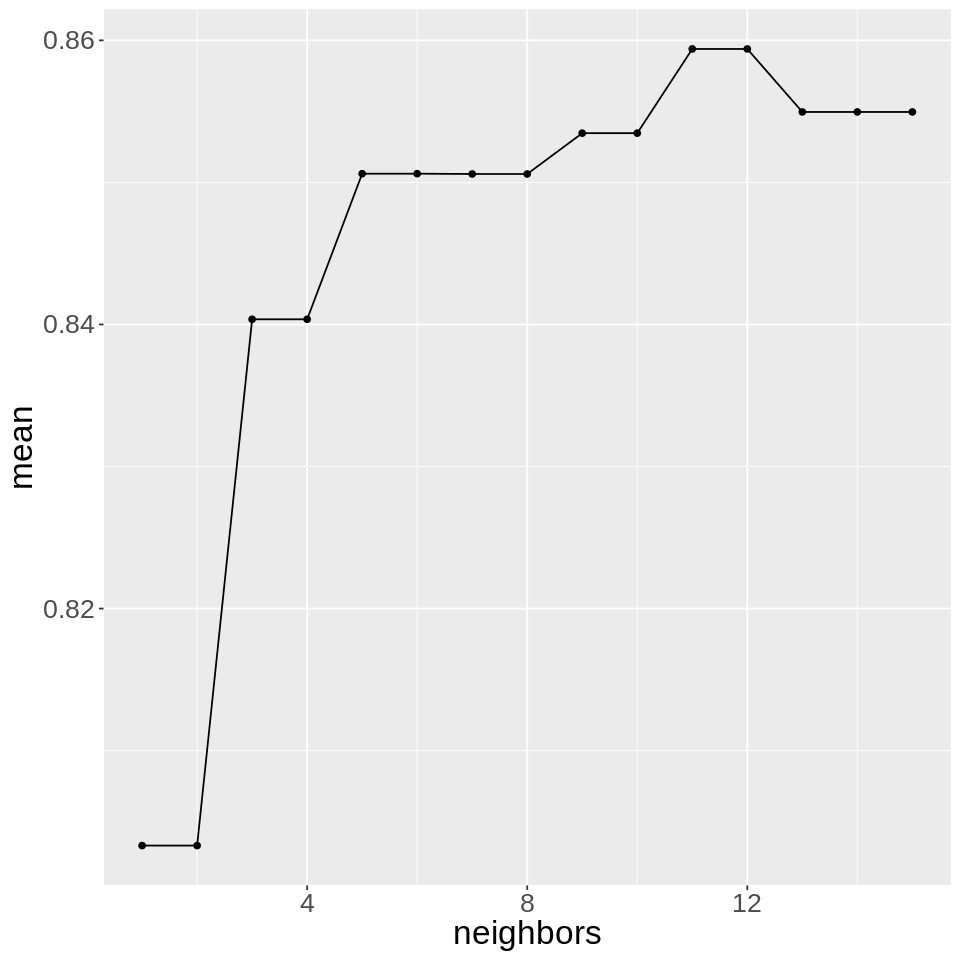

In [35]:
set.seed(5805)
raisin_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
    set_engine("kknn") %>%
    set_mode("classification") 

raisin_recipe <- recipe(Class ~ Perimeter + Eccentricity + Area, data = raisin_training) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors())
#do I need scale? yes I need. Should I mention y I need the scale?

onetotwenty <- tibble(neighbors = seq(1,20))
raisin_vfold <- vfold_cv(raisin_training, v = 5, strata = Class)
#should I justify y I am using 5 of v?

raisin_workflow <- workflow() %>%
    add_recipe(raisin_recipe) %>%
    add_model(raisin_spec) %>%
    tune_grid(resamples = raisin_vfold, grid = onetotwenty) %>%
#should I justify y I am using 10 ks?
    collect_metrics() %>%
    filter(.metric == "accuracy")

ggplot(raisin_workflow, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    theme(text = element_text(size = 20))

filtered_raisin_workflow <- filter(raisin_workflow, neighbors <= 15)
ggplot(filtered_raisin_workflow, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    theme(text = element_text(size = 20))

#### 3. predict and find accuracy on testing set; train and predict  

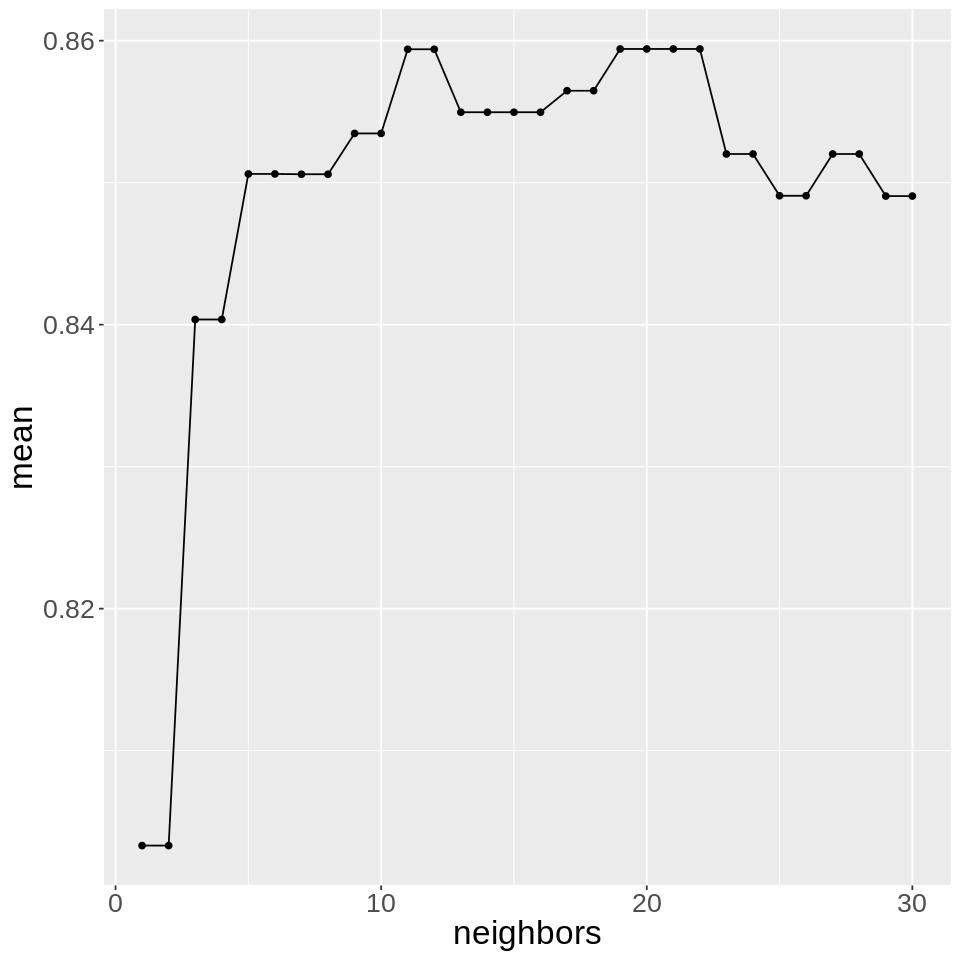

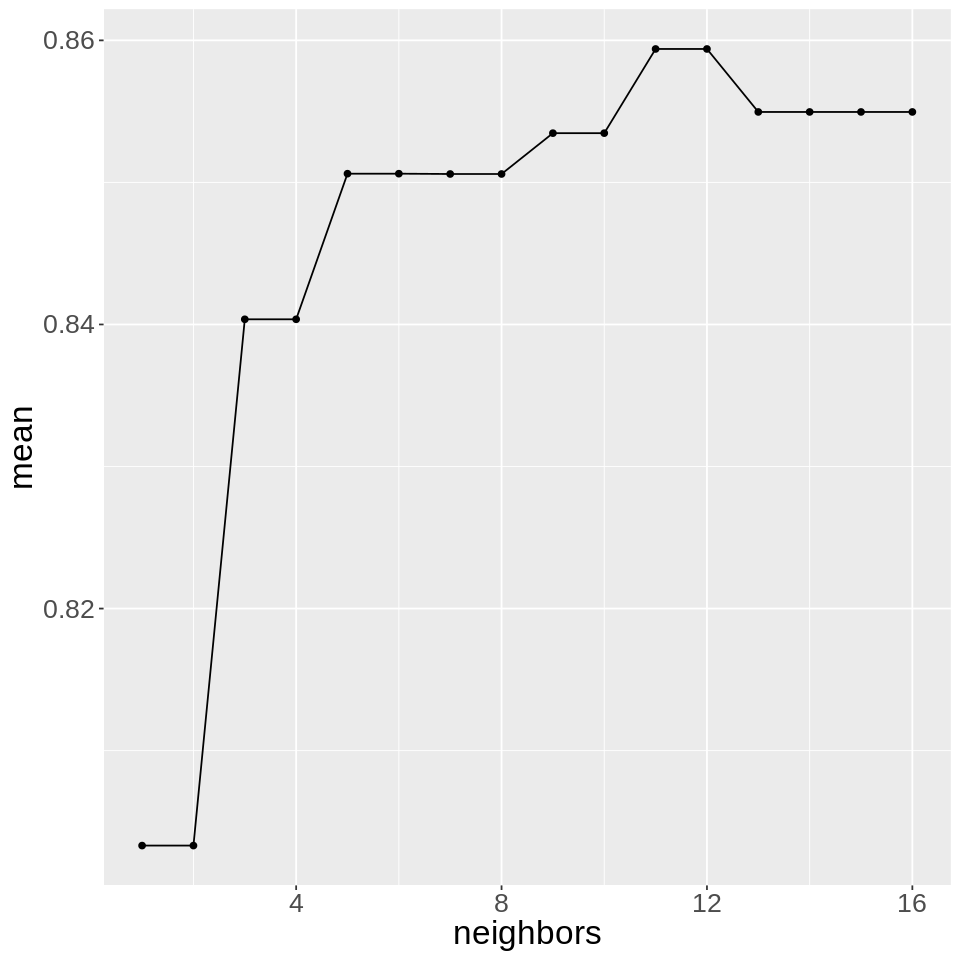

In [33]:
#tune first again to compare with other models that uses the all predictors for the models
set.seed(5805)
raisin_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
    set_engine("kknn") %>%
    set_mode("classification") 

raisin_recipe <- recipe(Class ~ Perimeter + Eccentricity + Area, data = raisin_training) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors())

onetotwenty <- tibble(neighbors = seq(1,30))
raisin_vfold <- vfold_cv(raisin_training, v = 5, strata = Class)

raisin_workflow <- workflow() %>%
    add_recipe(raisin_recipe) %>%
    add_model(raisin_spec) %>%
    tune_grid(resamples = raisin_vfold, grid = onetotwenty) %>%
    collect_metrics() %>%
    filter(.metric == "accuracy")

ggplot(raisin_workflow, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    theme(text = element_text(size = 20))

filtered_raisin_workflow <- filter(raisin_workflow, neighbors <= 16)
ggplot(filtered_raisin_workflow, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    theme(text = element_text(size = 20))

In [24]:
set.seed(5805)
raisin_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 11) %>%
    set_engine("kknn") %>%
    set_mode("classification") 

raisin_workflow <- workflow() %>%
    add_recipe(raisin_recipe) %>%
    add_model(raisin_best_spec) %>%
    fit(data = raisin_training) 

raisin_result <- raisin_workflow %>%
    predict(raisin_testing) %>%
    bind_cols(raisin_testing) 

raisin_accuracy <- raisin_result %>%
    metrics(truth = Class, estimate = .pred_class) %>%
    filter(.metric == "accuracy")
raisin_accuracy

raisin_conf_mat <- raisin_result %>%
    conf_mat(truth = Class, estimate = .pred_class)
raisin_conf_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8571429


          Truth
Prediction Kecimen Besni
   Kecimen      99    19
   Besni        13    93

finding: accuracy is 0.8303571

#### 4. compare the model prediction with other research model predictions

We have compared the KNN model's prediction to the raisin data and the research's models' predictions. The comparison and analysis were based on each model's performance measurements. (source) The measurements are Accuracy, Sensitivity, Specificity, Precision, F1-Score, Negative Predictive Value, False Positive Rate, False Discovery Rate, and False Negative Rate. The summary() function provided Accuracy, Sensitivity, Specificity, and Precision. Those acquired data were saved as KNN_conf_mat data frame. And we have added the missing measurements through calculations. For the calculation, tp (true positive), fp (false positive), fn (false negative), and tn (true negative) were acquired through a confusion matrix, and it was calculated according to the research's formula provided in Table 2. (source) 

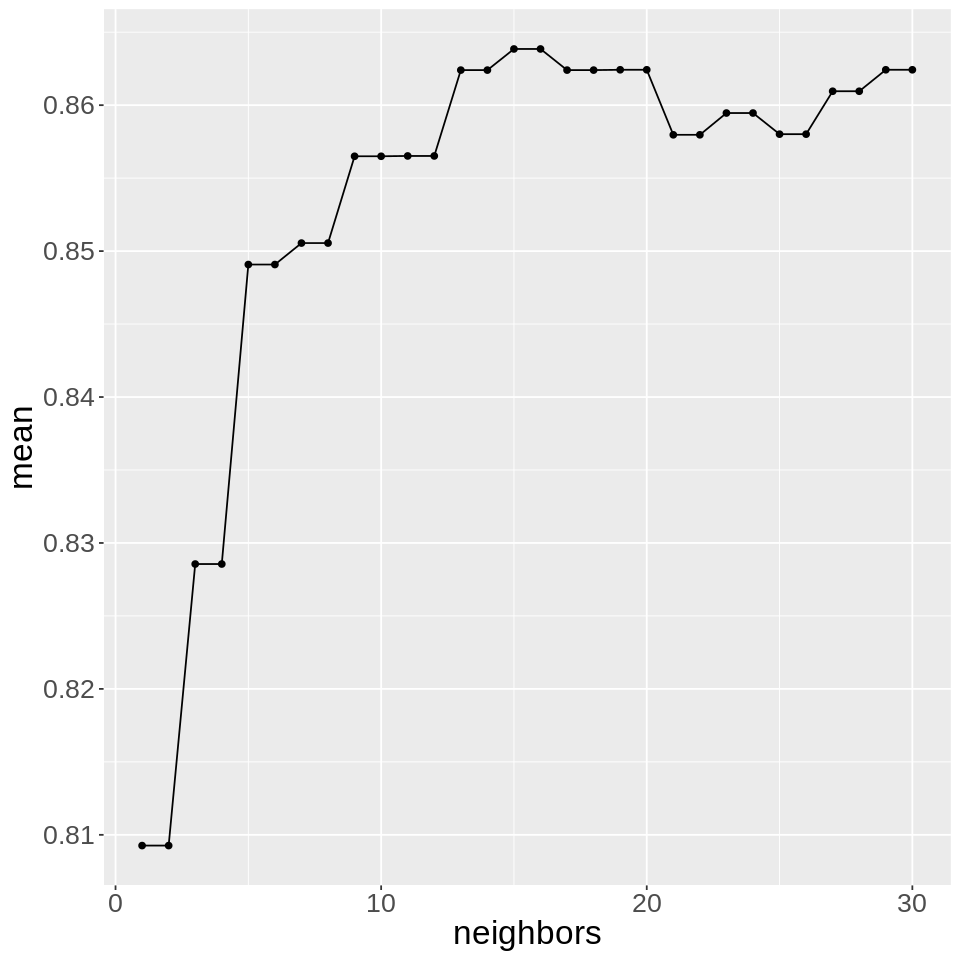

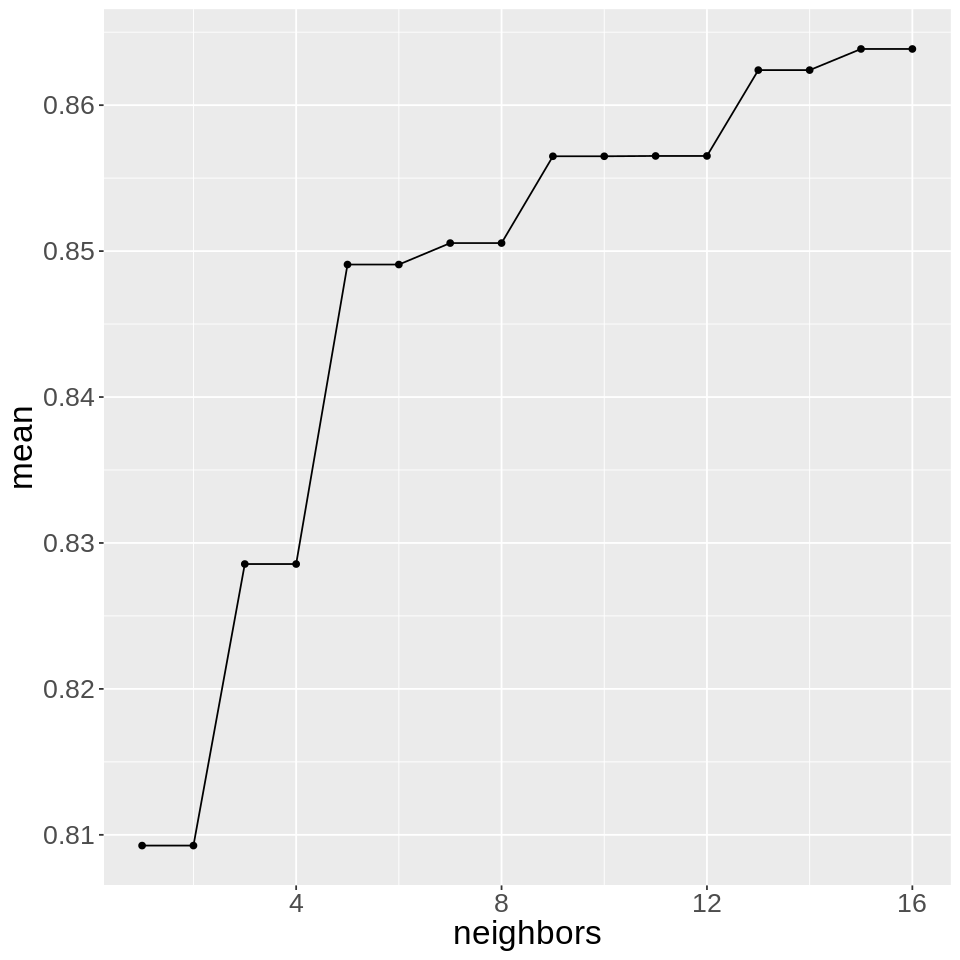

In [31]:
set.seed(5805)
raisin_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
    set_engine("kknn") %>%
    set_mode("classification") 

raisin_recipe <- recipe(Class ~ ., data = raisin_training) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors())

onetotwenty <- tibble(neighbors = seq(1,30))
raisin_vfold <- vfold_cv(raisin_training, v = 5, strata = Class)

raisin_workflow <- workflow() %>%
    add_recipe(raisin_recipe) %>%
    add_model(raisin_spec) %>%
    tune_grid(resamples = raisin_vfold, grid = onetotwenty) %>%
    collect_metrics() %>%
    filter(.metric == "accuracy")

ggplot(raisin_workflow, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    theme(text = element_text(size = 20))

filtered_raisin_workflow <- filter(raisin_workflow, neighbors <= 16)
ggplot(filtered_raisin_workflow, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    theme(text = element_text(size = 20))

In [32]:
set.seed(5805)
raisin_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 16) %>%
    set_engine("kknn") %>%
    set_mode("classification") 

raisin_workflow <- workflow() %>%
    add_recipe(raisin_recipe) %>%
    add_model(raisin_best_spec) %>%
    fit(data = raisin_training) 

raisin_result <- raisin_workflow %>%
    predict(raisin_testing) %>%
    bind_cols(raisin_testing) 

raisin_accuracy <- raisin_result %>%
    metrics(truth = Class, estimate = .pred_class) %>%
    filter(.metric == "accuracy")
raisin_accuracy

raisin_conf_mat <- raisin_result %>%
    conf_mat(truth = Class, estimate = .pred_class)
raisin_conf_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8571429


          Truth
Prediction Kecimen Besni
   Kecimen      99    19
   Besni        13    93

In [25]:
#data from raisin_conf_mat
tp <- 99
fp <- 19
fn <- 13
tn <- 93

#decided to use summary(raisin_conf_mat)
#filter and select the .metrics that also appeared on the research's performance measurements: accuracy, sens, spec, precision
KNN_conf_mat <- summary(raisin_conf_mat) %>%
    filter(.metric == "accuracy" | .metric == "sens" | .metric == "spec" | .metric == "precision") %>%
    select(.metric, .estimate) %>%
    mutate(.estimate = .estimate * 100)

#the missing metrics compared to the research is calculated according to the research's formula 
# Calculating missing values of F1_Score_KNN, Negative_Predictive_Value, False_Positive_Rate
#False_Discovery_Rate, and False_Negative_Rate of our KNN raisin data
F1_Score_KNN <- (((2*tp)/(2*tp + fp + fn)) * 100)
Negative_Predictive_Value <- ((tn / (tn + fn)) * 100)
False_Positive_Rate <- ((fp / (tn + fp)) * 100)
False_Discovery_Rate <- (fp / (tp + fp) * 100)
False_Negative_Rate <- (fn / (tp + fn) * 100)

#adding the calculated data to the KNN raisin data
KNN <- add_row(KNN_conf_mat, .metric = "F1_Score", .estimate = F1_Score_KNN) %>%
    add_row(.metric = "Negative_Predictive_Value", .estimate = Negative_Predictive_Value) %>%
    add_row(.metric = "False_Positive_Rate", .estimate = False_Positive_Rate) %>%
    add_row(.metric = "False_Discovery_Rate", .estimate = False_Discovery_Rate) %>%
    add_row(.metric = "False_Negative_Rate", .estimate = False_Negative_Rate) 

KNN <- KNN %>%
    mutate(.estimate = round(.estimate, digit = 2))
KNN

.metric,.estimate
<chr>,<dbl>
accuracy,85.71
sens,88.39
spec,83.04
precision,83.90
F1_Score,86.09
Negative_Predictive_Value,87.74
False_Positive_Rate,16.96
False_Discovery_Rate,16.10
False_Negative_Rate,11.61


The research used three models: LR (Logistic Regression), MLP (Multilayer Perceptron), and SVM (Support Vector Machine). (source; should I include the explanations for each model?) First, we manually input the data by reading and directly putting them into the rows. Then, we merged the two data frames into one. 

In [26]:
#manually inputting data frame for the Table 2 of the research 
measure_labels <- c("Accuracy", "Sensivity", "Specificity", "Precision", "F1-Score",
                    "Negative_Predictive_Value", "False_Positive_Rate", "False_Discovery_Rate",
                    "False_Negative_Rate")

measure_lr <- c(85.22, 84.09, 86.44, 86.89, 85.46, 83.56, 13.56, 13.11, 15.91)
measure_mlp <- c(86.33, 84.57, 88.29, 88.89, 86.67, 83.78, 11.71, 11.11, 15.41)
measure_svm <- c(86.44, 84.17, 89.05, 89.78, 86.88, 83.11, 10.95, 10.22, 15.83)

measurements <- tibble(performance_measure = measure_labels, LR = measure_lr, MLP = measure_mlp, SVM = measure_svm)
measurements

performance_measure,LR,MLP,SVM
<chr>,<dbl>,<dbl>,<dbl>
Accuracy,85.22,86.33,86.44
Sensivity,84.09,84.57,84.17
Specificity,86.44,88.29,89.05
Precision,86.89,88.89,89.78
F1-Score,85.46,86.67,86.88
Negative_Predictive_Value,83.56,83.78,83.11
False_Positive_Rate,13.56,11.71,10.95
False_Discovery_Rate,13.11,11.11,10.22
False_Negative_Rate,15.91,15.41,15.83


In [27]:
#binding our KNN data to the research's data frame and tidying the dataframe
comparison_models <- measurements %>%
    bind_cols(
        select(KNN, .estimate)) %>%
    rename(KNN = .estimate)

comparison_models

comparison_changed <- as.data.frame(t(comparison_models))
comparison_changed

rownames(comparison_changed) <- NULL
comparison_changed

comparison_tidy <- select(comparison_changed, V1:V9) %>%
    rename(Accuracy = V1) %>%
    rename(Sensivity = V2) %>%
    rename(Specificity = V3) %>%
    rename(Precision = V4) %>%
    rename(F1_Score = V5) %>%
    rename(Negative_Predictive_Value = V6) %>%
    rename(False_Positive_Rate = V7) %>%
    rename(False_Discovery_Rate = V8) %>%
    rename(False_Negative_Rate = V9) %>%
    mutate(Models = c("NULL", "LR", "MLP", "SVM", "KNN")) %>%
    filter(Models != "NULL")
comparison_tidy

performance_measure,LR,MLP,SVM,KNN
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Accuracy,85.22,86.33,86.44,85.71
Sensivity,84.09,84.57,84.17,88.39
Specificity,86.44,88.29,89.05,83.04
Precision,86.89,88.89,89.78,83.90
F1-Score,85.46,86.67,86.88,86.09
Negative_Predictive_Value,83.56,83.78,83.11,87.74
False_Positive_Rate,13.56,11.71,10.95,16.96
False_Discovery_Rate,13.11,11.11,10.22,16.10
False_Negative_Rate,15.91,15.41,15.83,11.61


,V1,V2,V3,V4,V5,V6,V7,V8,V9
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
performance_measure,Accuracy,Sensivity,Specificity,Precision,F1-Score,Negative_Predictive_Value,False_Positive_Rate,False_Discovery_Rate,False_Negative_Rate
LR,85.22,84.09,86.44,86.89,85.46,83.56,13.56,13.11,15.91
MLP,86.33,84.57,88.29,88.89,86.67,83.78,11.71,11.11,15.41
SVM,86.44,84.17,89.05,89.78,86.88,83.11,10.95,10.22,15.83
KNN,85.71,88.39,83.04,83.90,86.09,87.74,16.96,16.10,11.61


V1,V2,V3,V4,V5,V6,V7,V8,V9
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
Accuracy,Sensivity,Specificity,Precision,F1-Score,Negative_Predictive_Value,False_Positive_Rate,False_Discovery_Rate,False_Negative_Rate
85.22,84.09,86.44,86.89,85.46,83.56,13.56,13.11,15.91
86.33,84.57,88.29,88.89,86.67,83.78,11.71,11.11,15.41
86.44,84.17,89.05,89.78,86.88,83.11,10.95,10.22,15.83
85.71,88.39,83.04,83.90,86.09,87.74,16.96,16.10,11.61


Accuracy,Sensivity,Specificity,Precision,F1_Score,Negative_Predictive_Value,False_Positive_Rate,False_Discovery_Rate,False_Negative_Rate,Models
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
85.22,84.09,86.44,86.89,85.46,83.56,13.56,13.11,15.91,LR
86.33,84.57,88.29,88.89,86.67,83.78,11.71,11.11,15.41,MLP
86.44,84.17,89.05,89.78,86.88,83.11,10.95,10.22,15.83,SVM
85.71,88.39,83.04,83.90,86.09,87.74,16.96,16.10,11.61,KNN


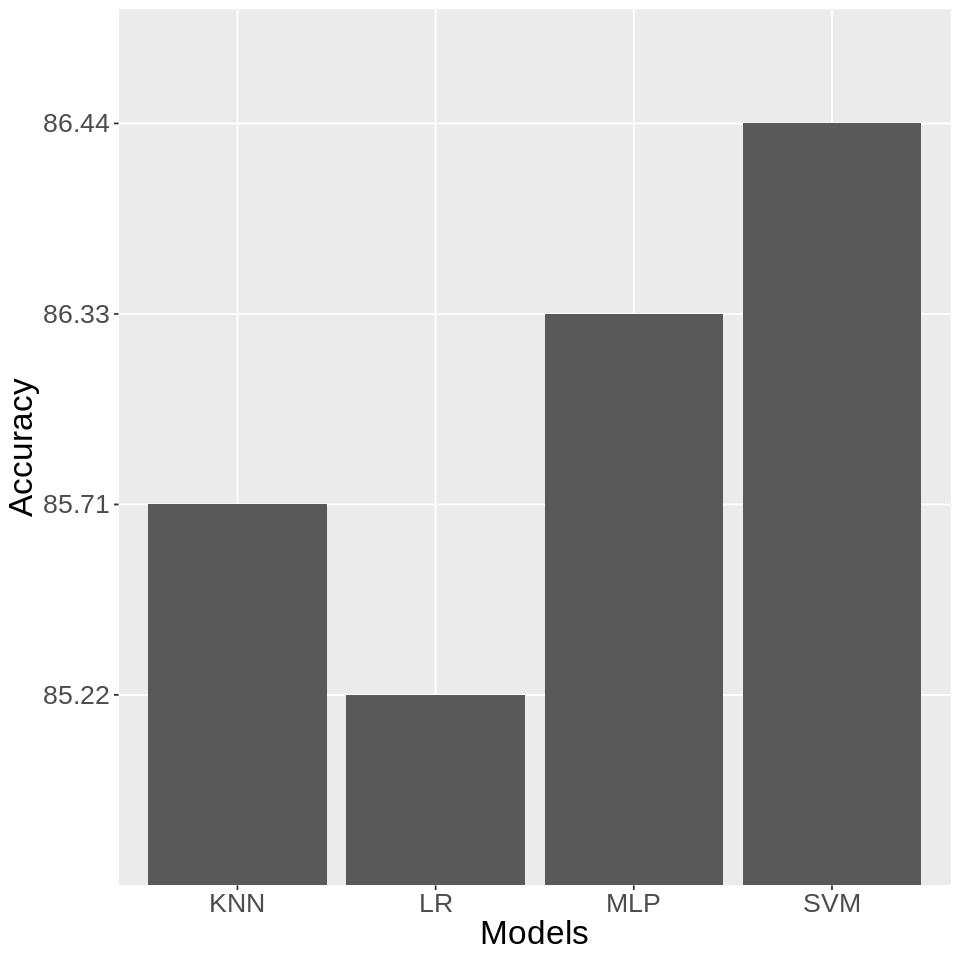

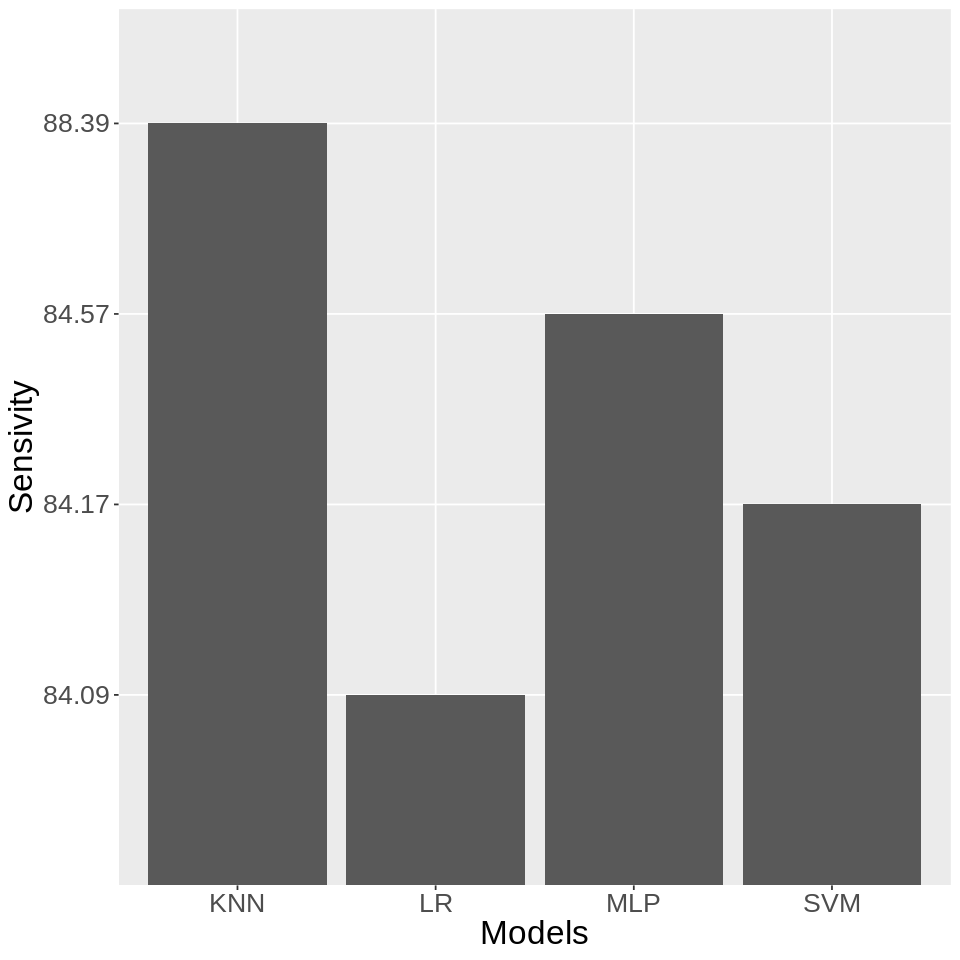

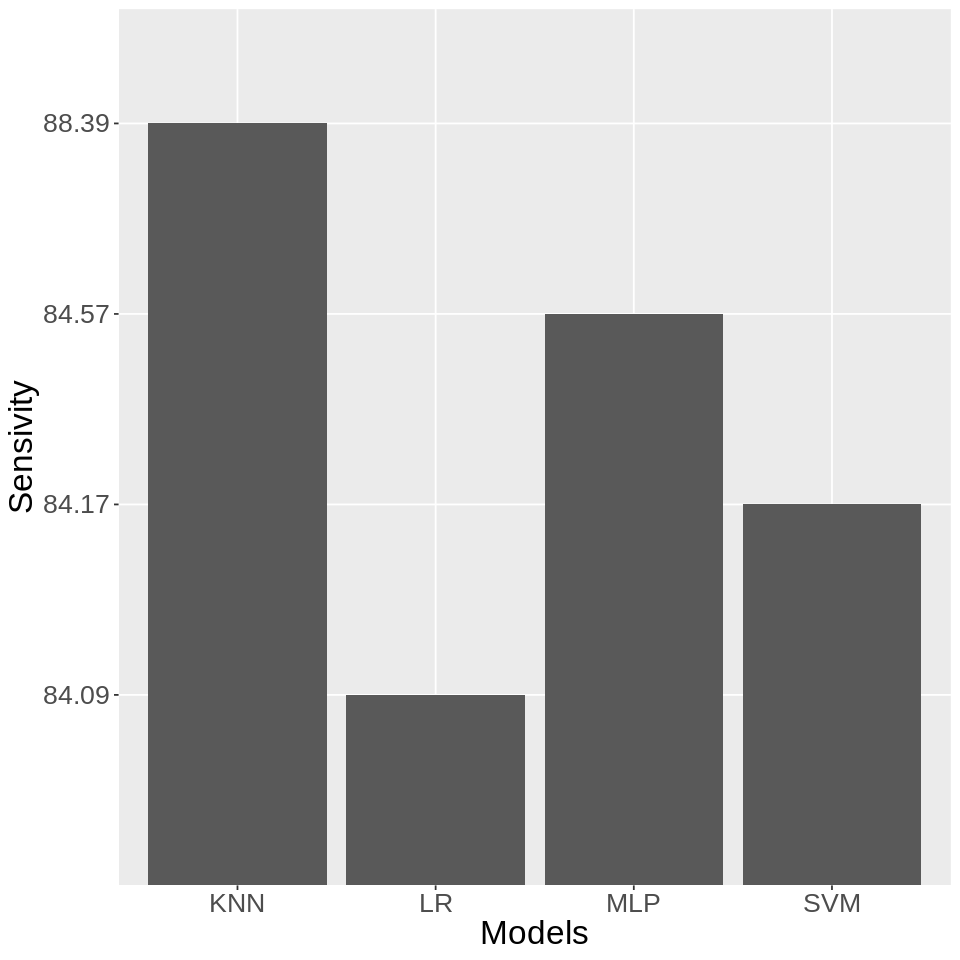

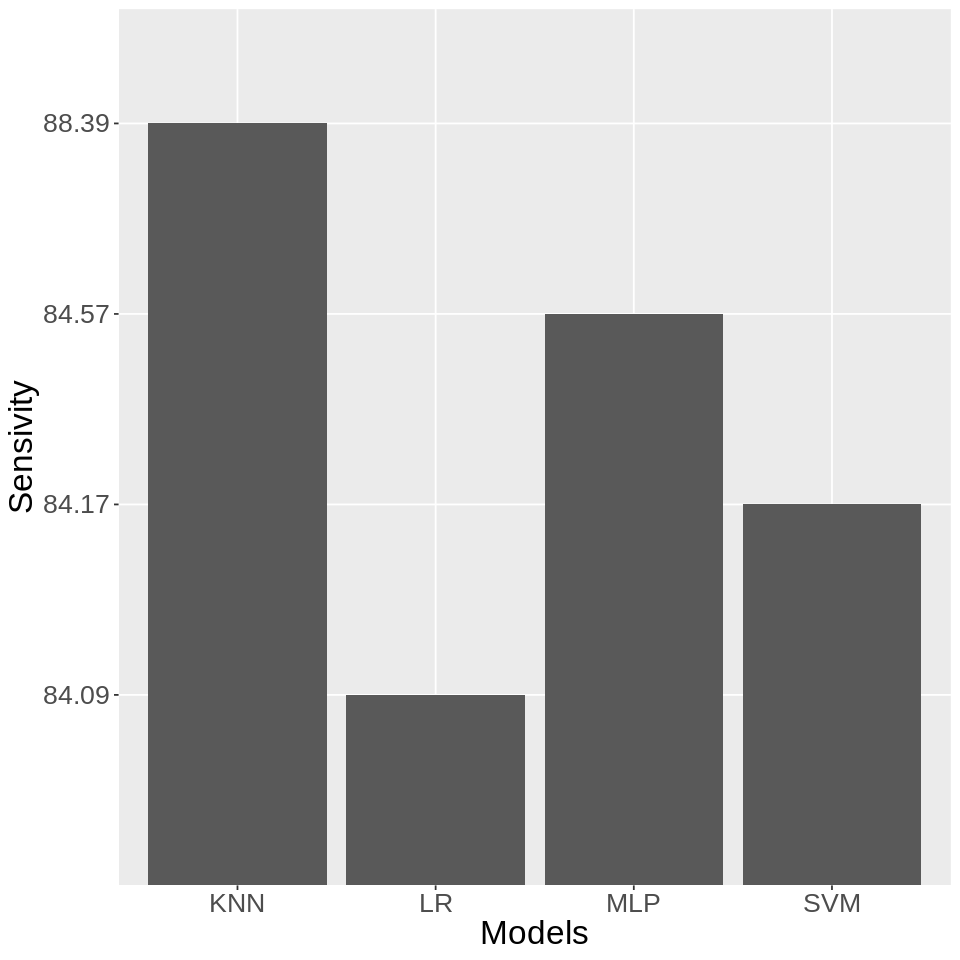

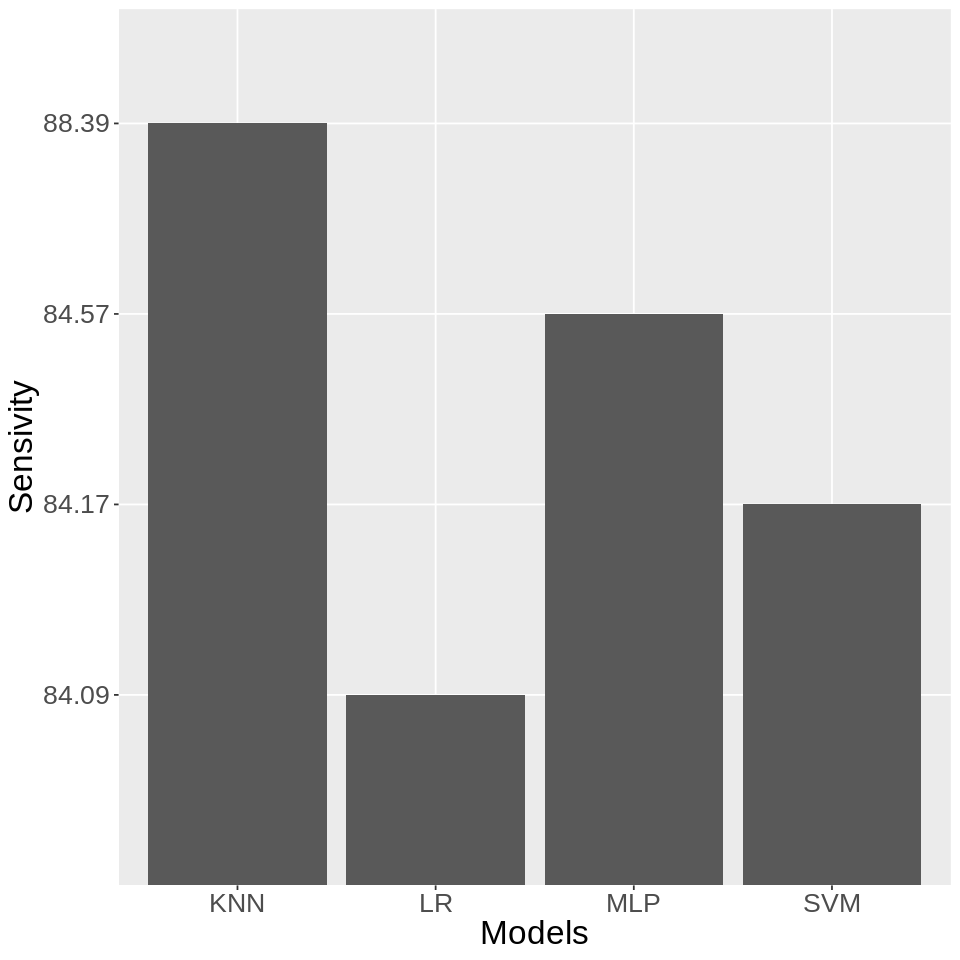

In [30]:
Accuracy_plot <- ggplot(comparison_tidy, aes(x = Models, y = Accuracy)) + 
    geom_bar(stat = "identity") +
    theme(text = element_text(size = 20))
Accuracy_plot

Sensivity_plot <- ggplot(comparison_tidy, aes(x = Models, y = Sensivity)) + 
    geom_bar(stat = "identity")+
    theme(text = element_text(size = 20))
Sensivity_plot

Specifity_plot <- ggplot(comparison_tidy, aes(x = Models, y = Specificity)) + 
    geom_bar(stat = "identity")+
    theme(text = element_text(size = 20))
Sensivity_plot

Precision_plot <- ggplot(comparison_tidy, aes(x = Models, y = Precision)) + 
    geom_bar(stat = "identity")+
    theme(text = element_text(size = 20))
Sensivity_plot

F1_Score_plot <- ggplot(comparison_tidy, aes(x = Models, y = F1_Score)) + 
    geom_bar(stat = "identity")+
    theme(text = element_text(size = 20))
Sensivity_plot
